# **Librerias**

In [1]:
# Importamos las Librerias 

import plotly
import matplotlib
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatText
from sklearn.datasets import make_regression

# Versiones 

print(f'Numpy Version: {np.__version__}')
print(f'CVXPY Version: {cp.__version__}')
print(f'Ploty Version: {plotly.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.3.1
CVXPY Version: 1.7.1
Ploty Version: 6.3.0
Matplotlib Version: 3.10.3


# **Dataset**

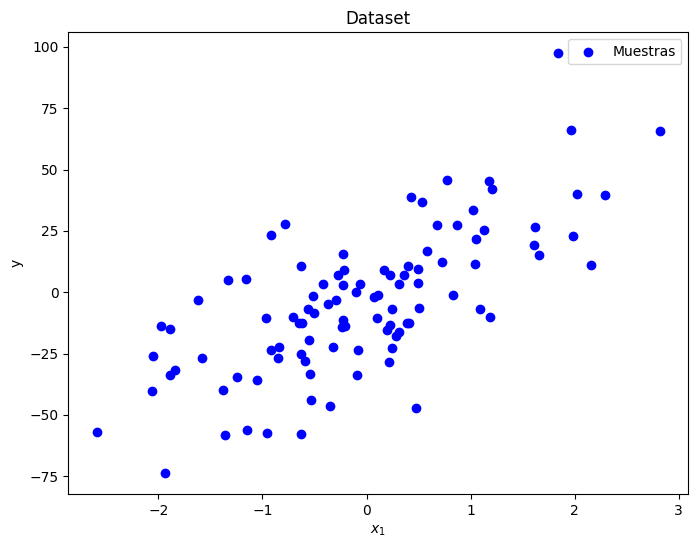

In [2]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Visualizamos

plt.figure(figsize = (8,6))

plt.scatter(X, y, color = 'blue', label = 'Muestras')

plt.xlabel('$x_1$')
plt.ylabel('y')
plt.title('Dataset')

plt.legend()
plt.show()

# **Ridge**

El método de **Ridge** en **regresión lineal** se obtiene como el **estimador de maximo a posteriori** (MAP) cuando se asume que las observaciones $y_i$ son independientes y provienen de una **distribución normal** con media $w^T x$ y varianza constante $\sigma^2$, a su vez la creencia a priori asume que los pesos $w_j$ provienen de una **distribucion normal** con media $0$ y varianza constante $\tau^2$

$$p(w \mid y, \theta) \propto p(w) \cdot p(y \mid w, \theta)$$
$$p(w \mid y, X, \sigma^2, \tau^2) \propto \mathcal{N}(w \mid 0, \tau^2 I_D) \cdot \mathcal{N}(y \mid Xw, \sigma^2 I_n)$$
$$p(w \mid y, X, \sigma^2, \tau^2) \propto \prod_{j=1}^D \frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{(w_j - 0)^2}{2\tau^2}} \cdot \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}$$

**Priori** 

$$p(w) = \prod_{j=1}^D \frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{(w_j - 0)^2}{2\tau^2}}$$

**Verosimilitud**

$$p(y \mid w, \theta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}$$

**Log Posteriori**  

$$LL(w \mid y, X, \sigma^2, \tau^2) = \log \left(\prod_{j=1}^D \frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{(w_j - 0)^2}{2\tau^2}} \cdot \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$
$$LL(w \mid y, X, \sigma^2, \tau^2)  = \log \left(\prod_{j=1}^D \frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{(w_j - 0)^2}{2\tau^2}}\right) + \log \left(\prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$
$$LL(w \mid y, X, \sigma^2, \tau^2)  = \sum_{j=1}^D \log \left(\frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{(w_j - 0)^2}{2\tau^2}}\right) + \sum_{i=1}^n \log \left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$
$$LL(w \mid y, X, \sigma^2, \tau^2)  = \sum_{j=1}^D \log \left(\frac{1}{\sqrt{2\pi\tau^2}} \cdot e^{-\frac{1}{2\tau^2} w_j^2}\right) + \sum_{i=1}^n \log \left(\frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(y_i - w^T x_i)^2}{2\sigma^2}}\right)$$


$$LL(w \mid y, X, \sigma^2, \tau^2)  = - \frac{D}{2} \log \left(2 \pi \tau^2\right) -\frac{1}{2\tau^2} w^Tw  - \frac{n}{2} \log \left(2\pi\sigma^2\right) - \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

**Negative Log Posteriori** 

$$NLL(w \mid y, X, \sigma^2, \tau^2)  = \frac{D}{2} \log \left(2 \pi \tau^2\right) + \frac{1}{2\tau^2} w^Tw  + \frac{n}{2} \log \left(2\pi\sigma^2\right) + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

**Nota:** Usamos el **Negative Log Posteriori** ya que convertimos un problema de maximizacion en minimizacion lo cual es mas estable computacionalmente

In [3]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, weights, sigma2, b, norm = True): 

    n = len(y) 

    log_likehood = np.zeros_like(weights, dtype = float)

    for idx, weight in enumerate(weights): 

        residuals = y - (X * weight + b)

        log_likehood[idx] = - ((n / 2) * np.log(2 * np.pi * sigma2)) - ((1 / (2 * sigma2)) * np.sum(residuals**2))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood 

# Definimos la Priori (Evitamos Overflow) 

def priori(weights, tau2, norm = True): 

    log_prior = np.zeros_like(weights, dtype = float) 

    for idx, weight in enumerate(weights): 

        log_prior[idx] = - (0.5 * np.log(2 * np.pi * tau2)) - ((1 / (2 * tau2)) * weight**2)

    if norm:
        log_prior = np.exp(log_prior - np.max(log_prior)) / np.sum(np.exp(log_prior - np.max(log_prior)))

    return log_prior 

# Definimos la Posteriori (Evitamos Overflow) 

def posteriori(X, y, weights, sigma2, tau2, b):

    log_prior = priori(weights, tau2, norm = False)
    log_likehood = likelihood(X, y, weights, sigma2, b, norm = False) 

    log_posterior = log_prior + log_likehood

    log_posterior = np.exp(log_posterior - np.max(log_posterior)) / np.sum(np.exp(log_posterior - np.max(log_posterior)))

    return log_posterior

# Visualizamos 

w_vals = np.linspace(-10, 30, 1000)

def viz(sigma2 = 1, tau2 = 1, w = 0, b = 0):

    log_prior = priori(w_vals, tau2)
    log_likehood = likelihood(X, y, w_vals, sigma2, b) 
    log_posterior = posteriori(X, y, w_vals, sigma2, tau2, b)
    
    fig, axes = plt.subplots(1, 2, figsize = (24,6))

    y_pred = w * X + b

    axes[0].scatter(X, y, label = "Muestras", color = "black")
    axes[0].plot(X, y_pred, color = "blue", label = rf"$y = {w:0.2f}x + {b}$" if np.sign(b) == 1 else rf"$y = {w:0.2f}x {b}$")
    
    for xi, yi, ypi in zip(X, y, y_pred):
        axes[0].plot([xi, xi], [yi, ypi], color = "red", linestyle = "--", alpha = 0.7)
    
    axes[0].set_title(f"Regresion Lineal")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("y")
    axes[0].legend()

    axes[1].plot(w_vals, log_likehood, label = "Likelihood", color = "green")
    axes[1].plot(w_vals, log_prior, label = "Prior", color = "blue")
    axes[1].plot(w_vals, log_posterior, label = "Posterior", color = "red")
    axes[1].axvline(x = w, color = "blue", linestyle = "--", label = rf"$w_1$ = {w}")
    axes[1].set_title("MAP")
    axes[1].set_xlabel(r"$w_1$")
    axes[1].set_ylabel("PDF")
    axes[1].legend()

    plt.tight_layout()
    return plt.show()

interact(viz, sigma2 = FloatText(value = 1, description = 'sigma2'), tau2 = FloatText(value = 1, description = 'tau2'), w = FloatText(value = 0, description = 'w'), b = FloatText(value = 0, description = 'b'))
plt.show()


interactive(children=(FloatText(value=1.0, description='sigma2'), FloatText(value=1.0, description='tau2'), Fl…

### **Solucion Analitica** 

**Derivamos Pracialmente Respecto a los Parametros** 

* Parametro: $w$ 

$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{2\tau^2} w^Tw  + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$
$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{2\tau^2} \left[w^Tw\right]  + \frac{1}{2 \sigma^2} \left[y^Ty - y^TXw - w^TX^Ty + w^TX^TXw\right]$$
$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{2\tau^2} \left[w^Tw\right] + \frac{1}{2 \sigma^2} \left[y^Ty - 2 y^TXw + w^TX^TXw\right]$$
$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{2\tau^2} \left[dw^Tw+ w^Tdw\right] + \frac{1}{2 \sigma^2} \left[- 2 y^TXdw + dw^TX^TXw + w^TX^TXdw\right]$$
$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{2\tau^2} \left[2 w^Tdw\right] + \frac{1}{2 \sigma^2} \left[- 2 y^TXdw + 2 w^TX^TXdw\right]$$
$$\frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = \frac{1}{\tau^2} \left[w^Tdw\right] + \frac{1}{\sigma^2} \left[w^TX^TXdw - y^TXdw \right]$$

$$\nabla_w^T = \frac{1}{\tau^2} \left[w^T\right] + \frac{1}{\sigma^2} \left[w^TX^TX - y^TX\right]$$
$$\nabla_w = \frac{1}{\tau^2} \left[w\right] + \frac{1}{\sigma^2} \left[X^TXw - X^Ty\right]$$

**Máximo a Posteriori** 

* Parametro: $w$ 

$$\hat{w}_{MAP} = \text{argmin}_{w} NLL(w^T x, \sigma^2) \rightarrow \frac{\partial NLL(w \mid y, X, \sigma^2, \tau^2)}{\partial w} = 0$$

$$0 = \frac{1}{\tau^2} \left[w\right] + \frac{1}{\sigma^2} \left[X^TXw - X^Ty\right]$$
$$\frac{1}{\sigma^2} \left[X^Ty\right] = \frac{1}{\tau^2} \left[w\right] + \frac{1}{\sigma^2} \left[X^TXw\right]$$
$$X^Ty = \frac{\sigma^2}{\tau^2} w + X^TXw$$
$$X^Ty = \left(\frac{\sigma^2}{\tau^2} I + X^TX\right) w$$
$$w = \left(\frac{\sigma^2}{\tau^2} I  + X^TX\right)^{-1} X^Ty$$

En donde

* $\lambda = \frac{\sigma^2}{\tau^2}$

**Nota:** $\left(\frac{\sigma^2}{\tau^2} I  + X^TX\right)$  es siempre invertible



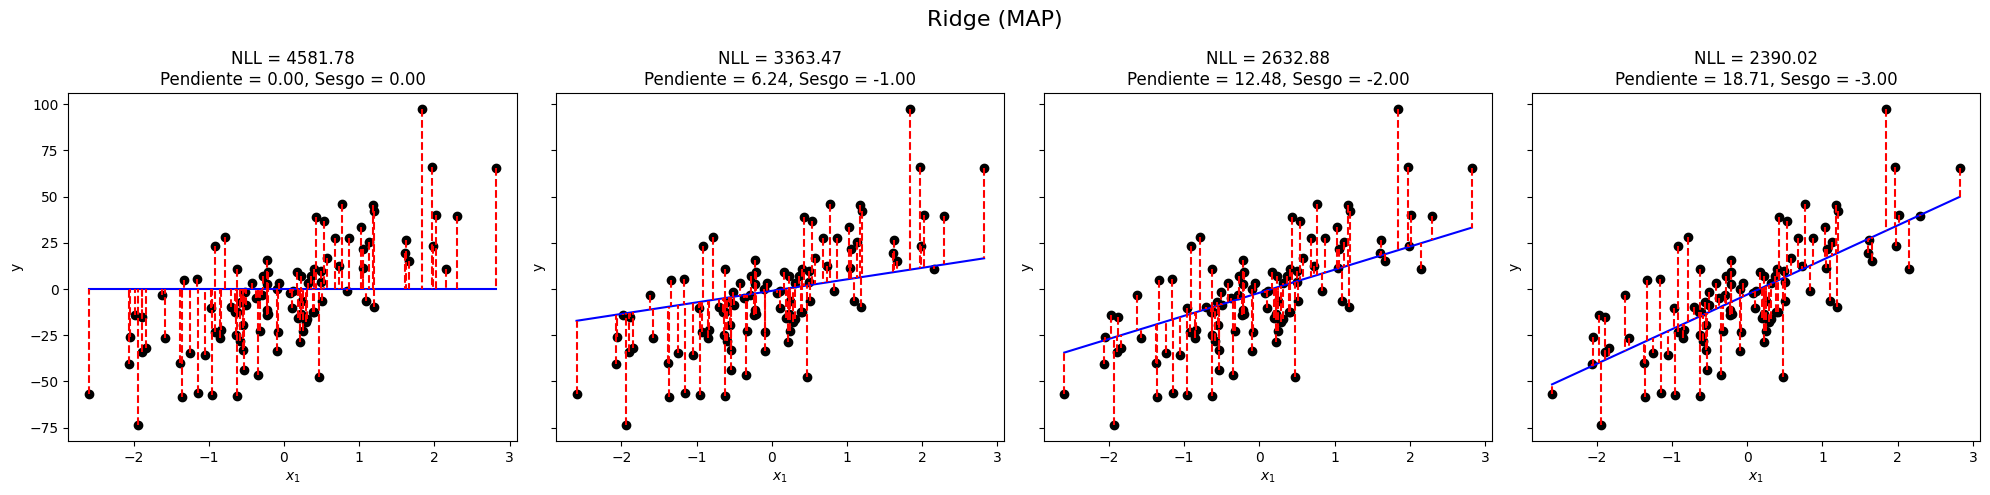

In [4]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Funcion de Negative Log-Likehood (Penalizamos solo los Pesos no el Sesgo por eso D-1)

def NLL(X, w, sigma2 = 1, tau2 = 1): 

    n = X.shape[0]    
    D = X.shape[1] - 1

    resid = y - X @ w

    nll_prior = (D / 2) * np.log(2 * np.pi * tau2) + (w @ w) / (2 * tau2)
    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    nll = nll_prior + nll_likelihood

    return nll   

# Obtenemos el parametro de Maxima A Posteriori Analiticamente (Penalizamos solo los Pesos no el Sesgo --> identity)

sigma2 = 10
tau2 = 3

X_with_bias = np.vstack([np.ones_like(X), X]).T

identity = np.identity(X_with_bias.shape[1])
identity[0, :] = 0

w_opt = np.linalg.inv((sigma2 / tau2) * identity + X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y

m_opt = w_opt[1]
b_opt = w_opt[0]

# Definimos unos Pasos Intermedios a los optimos

n_steps = 4 
w_init = np.array([0, 0]) 

w_list = [w_init + (w_opt - w_init) * i / (n_steps-1) for i in range(n_steps)]

# Visualizamos 

fig, axes = plt.subplots(1, n_steps, figsize = (20,5), sharey = True)

for ax, weights in zip(axes, w_list):

    nll = NLL(X_with_bias, weights, sigma2, tau2)    

    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = weights[1]*x_line + weights[0]

    ax.scatter(X, y, color = 'black', label = 'Muestras')
    ax.plot(x_line, y_line, color = 'blue', label = 'Recta')

    for xi, yi in zip(X, y):
        y_pred = weights[1] * xi + weights[0]
        ax.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')    
    
    ax.set_title(f'NLL = {nll :.2f}\nPendiente = {weights[1] :.2f}, Sesgo = {weights[0] :.2f}')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel('y')

plt.suptitle('Ridge (MAP)', fontsize = 16)
plt.tight_layout()
plt.show()

### **Solucion Convexa** 

Podemos calcular el parametro de **maximo a posteriori** $w$, como un problema de **optimizacion convexa** utilizando la funcion de **Negative Log-Verosimilitud**:

$$NLL(w \mid y, X, \sigma^2, \tau^2) = \frac{D}{2} \log 2 \pi \tau^2 + \frac{1}{2\tau^2} w^Tw  + \frac{n}{2} \log 2\pi\sigma^2 + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$

Nos quedamos con los terminos que dependen de $w$

$$\text{Loss} = \frac{1}{2\tau^2} w^Tw + \frac{1}{2 \sigma^2} \cdot (y - Xw)^T (y - Xw)$$
$$\text{Loss} = \frac{\sigma^2}{\tau^2} w^Tw + (y - Xw)^T (y - Xw)$$

Podemos resolverlo como un **problema convexo** sin restricciones 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_2^2 + \lambda ||w||_2^2 
\end{align*}$$

En donde 

$$\lambda = \frac{\sigma^2}{\tau^2}$$

* $\sigma^2$ grande, tenemos mas confianza en el **prior** ya que los datos son ruidosos 

* $\tau^2$ grande, tenemos mas confianza en el **likehood** ya que el prior es muy laxo 

* $\tau^2$ pequeño, tenemos mas confianza en el **prior** ya que el prior es muy restrictivo

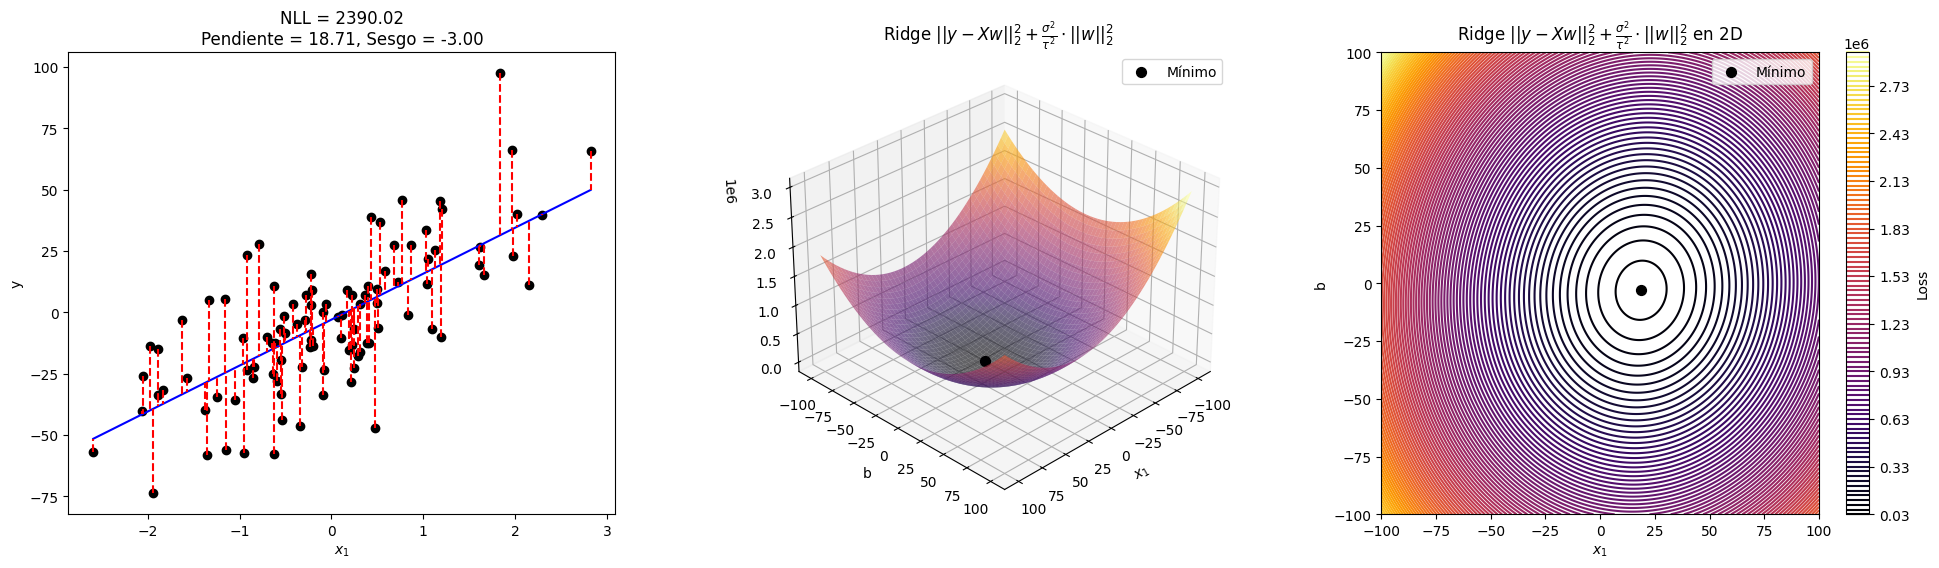

In [5]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)
X = X.flatten()

# Definimos la Funcion de Negative Log-Likehood (Penalizamos solo los Pesos no el Sesgo por eso D-1)

def NLL(X, w, sigma2 = 1, tau2 = 1): 

    n = X.shape[0]    
    D = X.shape[1] - 1

    resid = y - X @ w

    nll_prior = (D / 2) * np.log(2 * np.pi * tau2) + (w @ w) / (2 * tau2)
    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    nll = nll_prior + nll_likelihood

    return nll  

# Obtenemos el parametro de Maxima A Posteriori con Optimizacion

sigma2 = 10
tau2 = 3

X_with_bias = np.vstack([np.ones_like(X), X]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights) + (sigma2 / tau2) * weights[1]**2)

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, sigma2, tau2)  

# Visualizamos 

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection = '3d')
ax3 = fig.add_subplot(1, 3, 3)

x_line = np.linspace(X.min(), X.max(), 100)
y_line = w_opt[1]*x_line + w_opt[0]

ax1.scatter(X, y, color = 'black', label = 'Muestras')
ax1.plot(x_line, y_line, color = 'blue', label = 'Recta')

for xi, yi in zip(X, y):
    y_pred = w_opt[1] * xi + w_opt[0]
    ax1.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')    
    
ax1.set_title(f'NLL = {nll :.2f}\nPendiente = {w_opt[1] :.2f}, Sesgo = {w_opt[0] :.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('y')

m_vals = np.linspace(-100, 100, 500)
b_vals = np.linspace(-100, 100, 500)
M, B = np.meshgrid(m_vals, b_vals)

loss = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):

        y_pred_tmp = M[i, j] * X + B[i, j]
        loss[i, j] = np.sum((y - y_pred_tmp)**2) + (sigma2 / tau2) * M[i, j]**2

ax2.plot_surface(M, B, loss, cmap = 'inferno', alpha = 0.6)
ax2.scatter(m_opt, b_opt, np.sum((y - (m_opt * X + b_opt))**2 + (sigma2 / tau2) * m_opt**2), color = 'black', s = 50, label = 'Mínimo')

ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'b')
ax2.set_title(r'Ridge $||y - Xw||_2^2 + \frac{\sigma^2}{\tau^2} \cdot ||w||_2^2$')
ax2.view_init(elev = 30, azim = 45)
ax2.legend()

contours = ax3.contour(M, B, loss, levels = 100, cmap = 'inferno')

cbar = fig.colorbar(contours, ax = ax3)
cbar.set_label('Loss')

ax3.scatter(m_opt, b_opt, color = 'black', s = 50, label = 'Mínimo')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'b')
ax3.set_title(r'Ridge $||y - Xw||_2^2 + \frac{\sigma^2}{\tau^2} \cdot ||w||_2^2$ en 2D')
ax3.legend()

plt.show()

# **3D**

### **Dataset**

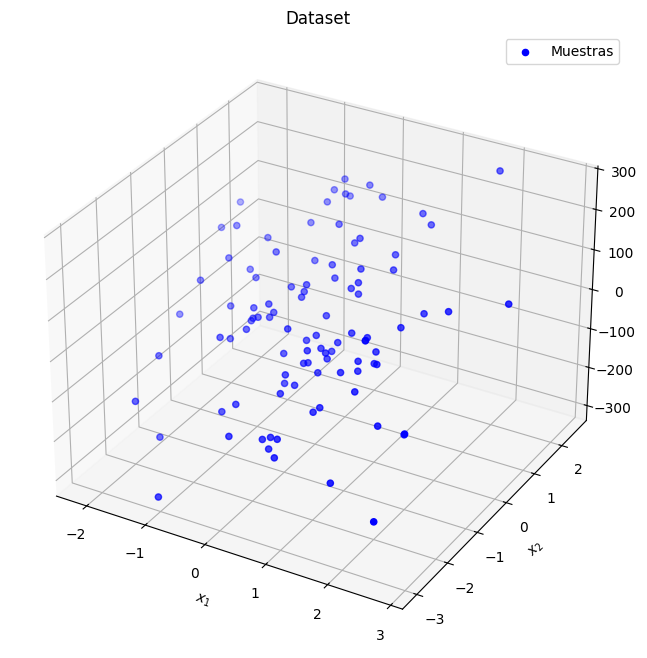

In [6]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Visualizamos

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], y, c = 'blue', marker = 'o', label = 'Muestras')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Dataset')

plt.legend()
plt.show()

In [7]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples=100, n_features=2, noise=20.0, random_state=25)

# Definimos la Verosimilitud (Evitamos Overflow)

def likelihood(X, y, W1, W2, sigma2, b, norm = True):

    n = len(y)

    log_likehood = np.zeros_like(W1, dtype = float)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):

            weight = np.array([W1[i,j], W2[i,j]]).reshape(-1)

            residuals = y - (X @ weight + b)

            log_likehood[i, j] = - ((n / 2) * np.log(2 * np.pi * sigma2)) - ((1 / (2 * sigma2)) * np.sum(residuals**2))

    if norm:
        log_likehood = np.exp(log_likehood - np.max(log_likehood)) / np.sum(np.exp(log_likehood - np.max(log_likehood)))

    return log_likehood

# Definimos la Priori (Evitamos Overflow)

def priori(W1, W2, tau2, norm = True):

    log_prior = - (0.5 * np.log(2 * np.pi * tau2)) - ((1 / (2 * tau2)) * ((W1)**2 + W2**2))

    if norm:
        log_prior = np.exp(log_prior - np.max(log_prior)) / np.sum(np.exp(log_prior - np.max(log_prior)))

    return log_prior

# Definimos la Posteriori (Evitamos Overflow)

def posteriori(X, y, W1, W2, sigma2, tau2, b):

    log_prior = priori(W1, W2, tau2, norm = False)
    log_likehood = likelihood(X, y, W1, W2, sigma2, b, norm = False)

    log_posterior = log_prior + log_likehood

    log_posterior = np.exp(log_posterior - np.max(log_posterior)) / np.sum(np.exp(log_posterior - np.max(log_posterior)))

    return log_posterior

# Visualizamos 

w1_vals = np.linspace(-20, 200, 200)
w2_vals = np.linspace(-20, 125, 500)

W1, W2 = np.meshgrid(w1_vals, w2_vals)

def viz(w1 = 0, w2 = 0, sigma2 = 1, tau2=1, b = 0):

    log_prior = priori(W1, W2, tau2, norm = True)
    log_likehood = likelihood(X, y, W1, W2, sigma2, b, norm = True)
    log_posterior = posteriori(X, y, W1, W2, sigma2, tau2, b)
   
    fig = plt.figure(figsize = (32,6))
    
    ax0 = fig.add_subplot(1, 4, 1)
    cs0 = ax0.contourf(W1, W2, log_likehood, levels = 100, cmap = 'viridis')
    ax0.plot(w1, w2, 'ro')
    ax0.set_title("Likelihood")
    ax0.set_xlabel(r"$w_1$")
    ax0.set_ylabel(r"$w_2$")
    ax0.set_xlim(0, 10)
    ax0.set_ylim(95, 100)
    fig.colorbar(cs0, ax = ax0)
    
    ax1 = fig.add_subplot(1, 4, 2)
    cs1 = ax1.contourf(W1, W2, log_prior, levels = 100, cmap = 'plasma')
    ax1.set_title("Prior")
    ax1.set_xlabel(r"$w_1$")
    ax1.set_ylabel(r"$w_2$")
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    fig.colorbar(cs1, ax = ax1)
    
    ax2 = fig.add_subplot(1, 4, 3)
    cs2 = ax2.contourf(W1, W2, log_posterior, levels = 100, cmap = 'inferno')
    ax2.set_title("Posterior")
    ax2.set_xlabel(r"$w_1$")
    ax2.set_ylabel(r"$w_2$")
    ax2.set_xlim(0, 20)
    ax2.set_ylim(80, 100)
    fig.colorbar(cs2, ax = ax2)

    ax3 = fig.add_subplot(1, 4, 4, projection='3d')
    x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
    x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

    X1, X2 = np.meshgrid(x1_line, x2_line)

    Y_plane = b + w1*X1 + w2*X2

    ax3.scatter(X[:,0], X[:,1], y, color = 'black', s = 20, label = "Muestras")
    ax3.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = 'red')
    ax3.set_xlabel(r'$x_1$')
    ax3.set_ylabel(r'$x_2$')
    
    plt.tight_layout()
    plt.show()

interact(viz, w1 = FloatText(value = 0, description = r'w1'), w2 = FloatText(value = 0, description = r'w2'), sigma2 = FloatText(value = 1, description = r'sigma2'), 
         tau2 = FloatText(value = 1, description = r'tau2'), b = FloatText(value = 0, description = r'b'))
plt.show()

interactive(children=(FloatText(value=0.0, description='w1'), FloatText(value=0.0, description='w2'), FloatTex…

### **Solucion Analitica**

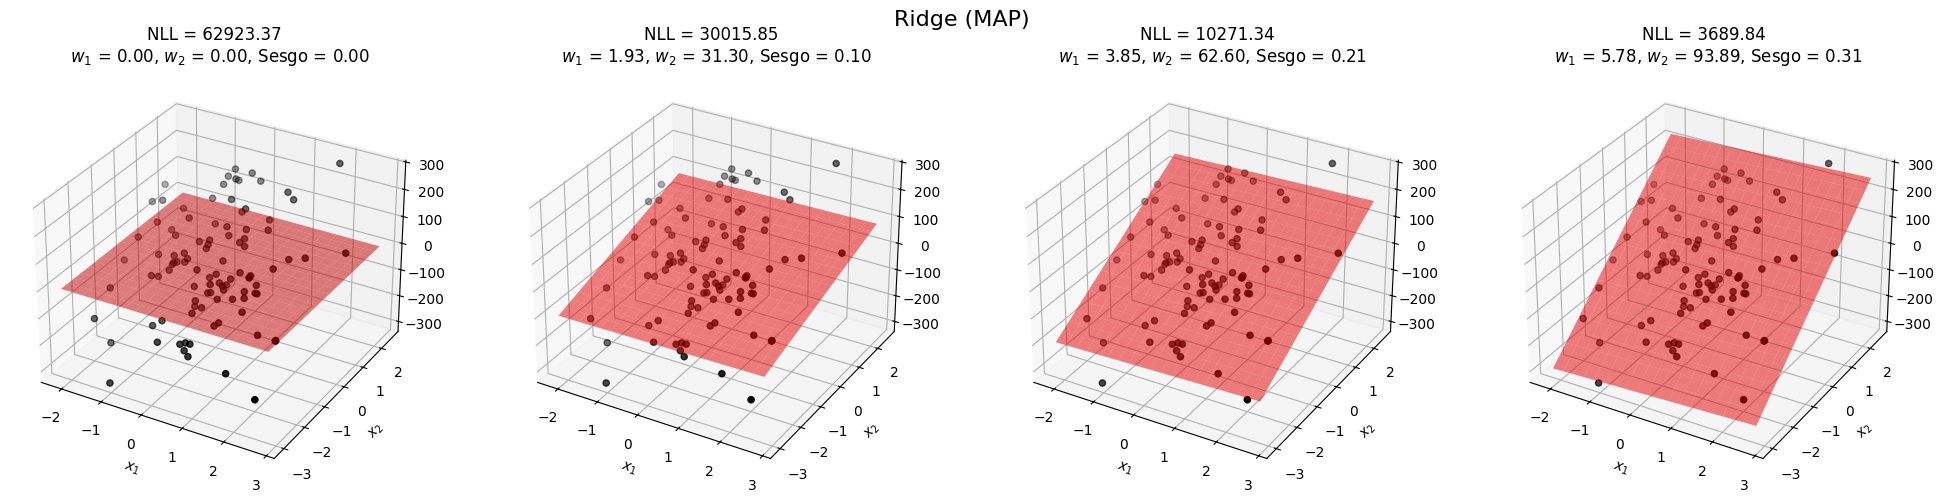

In [8]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Definimos la Funcion de Negative Log-Likehood (Penalizamos solo los Pesos no el Sesgo por eso D-1)

def NLL(X, w, sigma2 = 1, tau2 = 1): 

    n = X.shape[0]    
    D = X.shape[1] - 1

    resid = y - X @ w

    nll_prior = (D / 2) * np.log(2 * np.pi * tau2) + (w @ w) / (2 * tau2)
    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    nll = nll_prior + nll_likelihood

    return nll   

# Obtenemos el parametro de Maxima A Posteriori Analiticamente (Penalizamos solo los Pesos no el Sesgo --> identity)

sigma2 = 10
tau2 = 3

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

identity = np.identity(X_with_bias.shape[1])
identity[0, :] = 0

w_opt = np.linalg.inv((sigma2 / tau2) * identity + X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y

m_opt = w_opt[1]
b_opt = w_opt[0]

# Definimos unos Pasos Intermedios a los optimos

n_steps = 4 
w_init = np.array([0, 0, 0]) 

w_list = [w_init + (w_opt - w_init) * i / (n_steps-1) for i in range(n_steps)]

# Visualizamos 

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

X1, X2 = np.meshgrid(x1_line, x2_line)

fig = plt.figure(figsize = (20,5))

for idx, weights in enumerate(w_list, 1):

    ax = fig.add_subplot(1, n_steps, idx, projection = "3d")

    nll = NLL(X_with_bias, weights, sigma2, tau2)    

    Y_plane = weights[0] + weights[1]*X1 + weights[2]*X2

    ax.scatter(X[:,0], X[:,1], y, color = "black", s = 20, label = "Muestras")
    ax.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = "red", label = 'Plano') 
    
    ax.set_title(f'NLL = {nll:.2f} \n $w_1$ = {weights[1]:.2f}, $w_2$ = {weights[2]:.2f}, Sesgo = {weights[0]:.2f}')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')

plt.suptitle('Ridge (MAP)', fontsize = 16)
plt.tight_layout()
plt.show()

### **Solucion Convexa**

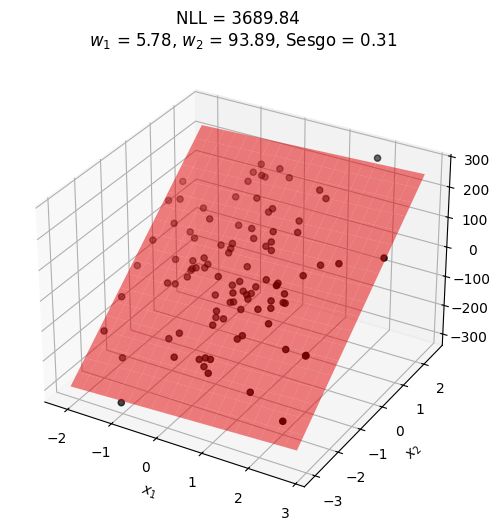

In [9]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 2, noise = 20.0, random_state = 25)

# Definimos la Funcion de Negative Log-Likehood (Penalizamos solo los Pesos no el Sesgo por eso D-1)

def NLL(X, w, sigma2 = 1, tau2 = 1): 

    n = X.shape[0]    
    D = X.shape[1] - 1

    resid = y - X @ w

    nll_prior = (D / 2) * np.log(2 * np.pi * tau2) + (w @ w) / (2 * tau2)
    nll_likelihood = (n / 2) * np.log(2 * np.pi * sigma2) + (resid @ resid) / (2 * sigma2) 

    nll = nll_prior + nll_likelihood

    return nll  

# Obtenemos el parametro de Maxima A Posteriori con Optimizacion

sigma2 = 10
tau2 = 3

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

weights = cp.Variable(3)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights) + (sigma2 / tau2) * cp.sum_squares(weights[1:]))

problem = cp.Problem(objective)
problem.solve()

w_opt = weights.value

m_opt = w_opt[1]
b_opt = w_opt[0]

# Calculamos Negative Log-Likehood 

y_pred = X_with_bias @ w_opt

nll = NLL(X_with_bias, w_opt, sigma2, tau2)  

# Visualizamos 

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_line = np.linspace(X[:,1].min(), X[:,1].max(), 20)

X1, X2 = np.meshgrid(x1_line, x2_line)

fig = plt.figure(figsize = (24,6))

ax1 = fig.add_subplot(1, 1, 1, projection = '3d')

Y_plane = b_opt + w_opt[1]*X1 + w_opt[2]*X2

ax1.scatter(X[:,0], X[:,1], y, color = "black", s = 20, label = "Muestras")
ax1.plot_surface(X1, X2, Y_plane, alpha = 0.5, color = "red") 
    
ax1.set_title(f'NLL = {nll:.2f} \n $w_1$ = {w_opt[1]:.2f}, $w_2$ = {w_opt[2]:.2f}, Sesgo = {b_opt:.2f}')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

plt.show()